In [1]:
import numpy as np
from slsim.Util.param_util import random_radec_string
from slsim.image_simulation import lens_image
from slsim.lsst_science_pipeline import (multiple_variable_lens_injection, 
                        dp0_time_series_images_data, multiple_variable_lens_injection)
import lsst.daf.butler as dafButler
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.lens_pop import LensPop
from slsim.Plots.plot_functions import create_image_montage_from_image_list

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-7.0.1/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


## Injection of variable lenses in dp0.2 data

This notebook shows how to use SLSim to simulate variable lens images and inject them to dp0.2 data.

It involves three steps:
1. Create a time series data from dp0 data using SLSim.
2. Based on the created time seies data, simulate variable lenses using SLSim.
3. Finally, inject variable lenses to time series data.

## Create a time series data

In [5]:
config = "dp02"
collection = "2.2i/runs/DP0.2"
butler = dafButler.Butler(config, collections=collection)
skymap = butler.get("skyMap")

In [6]:
radec_string = random_radec_string(ra_min=55, ra_max=70, dec_min=-43, dec_max=-30, n=5)

In [7]:
expo_data_list = []
for center_coords in radec_string:
    expo_data_list.append(dp0_time_series_images_data(butler, center_coords, radius="0.034", band='i', size=301))

## Define a tranform matrices for each exposure

Here we use the same tranform matrices for each exposure but they can be different for each exposure based on observational conditions.

In [8]:
transf_matrix_single = np.array([[0.2, 0], [0, 0.2]]) 
transform_matrices_list=[]
for data in expo_data_list:
    transform_matrices_list.append([transf_matrix_single.copy() for _ in range(len(data))])

## Simulate lens population

In [2]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


# define a sky area
sky_area = Quantity(value=0.1, unit="deg2")


# define limits in the intrinsic deflector and source population (in addition to the skypy config
# file)
kwargs_deflector_cut = {"band": "g", "band_max": 23, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "g", "band_max": 26, "z_min": 0.1, "z_max": 5.0}
kwargs_quasars = {'num_quasars':50000,
    'z_min':0.1,
    'z_max':5,
    'm_min':19,
    'm_max':25,
    'amp_min':0.95,
    'amp_max':1.1,
    'freq_min':0.5,
    'freq_max':0.6}
# run skypy pipeline and make galaxy-galaxy population class using LensPop
lens_pop = LensPop(
    deflector_type="all-galaxies",
    source_type="quasars",
    kwargs_deflector_cut=kwargs_deflector_cut,
    kwargs_source_cut=kwargs_source_cut,
    kwargs_quasars=kwargs_quasars,
    variability_model="sinusoidal",
    kwargs_variability={"amp": 1, "freq": 0.5},
    kwargs_mass2light=None,
    skypy_config=None,
    sky_area=sky_area,
    cosmo=cosmo,
)

## Select lenses for each time series data

In [8]:
kwargs_lens_cut = {"min_image_separation": 1, "max_image_separation": 10}
rgb_band_list = ["i", "r", "g"]
lens_class_list=[]
for i in range(len(expo_data_list)):
    lens_class_list.append(lens_pop.select_lens_at_random(**kwargs_lens_cut))

## Inject lenses to time series data

In [9]:
variable_lens_catalog = multiple_variable_lens_injection(lens_class_list, band='i', delta_pix=0.2, num_pix=301, 
                        transform_matrices_list=transform_matrices_list, exposure_data_list=expo_data_list)

/home/nkhadka/.local/lib/python3.11/site-packages/lenstronomy/Data/psf.py:80: UserWarning: Input PSF model has at least one negative element, which is unphysical except for a PSF of an interferometric array.
  warnings.warn(


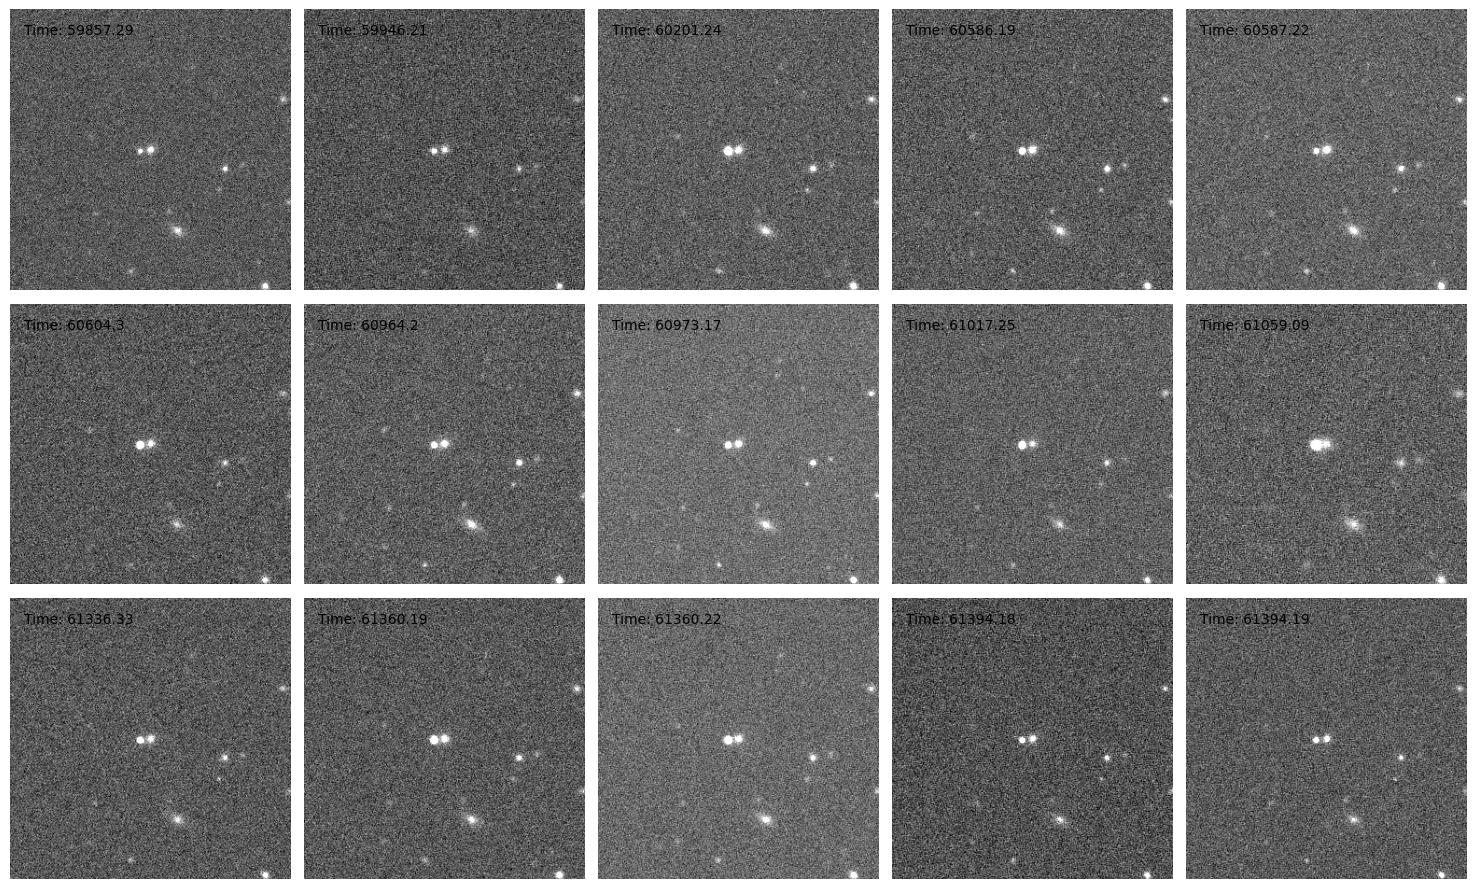

In [16]:
##plot each injected lens
plot_variable_lenses=create_image_montage_from_image_list(num_rows=3, num_cols=5, images=variable_lens_catalog[4]['injected_lens'], time=variable_lens_catalog[4]['obs_time'], image_type='dp0')